# Extension of Tatsat Predictive Modelling of Stock Returns

This notebook attempts to use ARIMA/SARIMAX time series models and daisy chained regression models and a neural network in order to predict the weekly returns of two stocks within the same sector - GE and MMM (3M).

In [1]:
import numpy as np
import pandas as pd
import pandas_datareader as web
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import datetime
import talib

#Data Visualization
#import tsplot
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import ndtr

#Data processing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

#Validation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression

#Scoring
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr
from sklearn.metrics import make_scorer 
import phik
from phik.report import plot_correlation_matrix

In [2]:
#Add Multiple target regression capabilities
from sklearn.multioutput import RegressorChain
from sklearn.multioutput import MultiOutputRegressor

#Supervised Regression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import MultiTaskLasso
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import MultiTaskElasticNet
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.cross_decomposition import PLSRegression

#Combination regressors
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import BaggingRegressor

#Deep learning
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import SGD
from keras.wrappers.scikit_learn import KerasRegressor

#Time Series

#from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

Using TensorFlow backend.


In [3]:
#AlphaLens for evaluation
import alphalens
from alphalens.tears import create_summary_tear_sheet
from alphalens.utils import get_clean_factor_and_forward_returns
from alphalens.tears import create_full_tear_sheet


#Suppress warnings
import warnings
warnings.simplefilter('ignore')

## Loading The Data

Two of the stocks for the companies in question are the targets. General Electric, 3M and Applied Materials Inc are considered.
The raw data to be used includes, not only the stock data but also the currencies of countries with some relations (US, Mexico, Japan) as well as US Indices such as the S&P, DOW etc... 

In [4]:
#Getting currency and Index Data
#stk_tickers = ['GE', 'MMM', 'AMAT']
ccy_tickers = ['DEXJPUS', 'DEXUSUK', 'DEXMXUS']
idx_tickers = ['SP500', 'DJIA', 'VIXCLS']

#stk_data = web.DataReader(stk_tickers, 'yahoo', start = "2000-01-03 00:00:00")
ccy_data = web.DataReader(ccy_tickers, 'fred', start = "2000-01-03 00:00:00", end = "2023-01-01 00:00:00")
idx_data = web.DataReader(idx_tickers, 'fred', start = "2000-01-03 00:00:00", end = "2023-01-01 00:00:00")

#Getting stock Data
df = pd.read_csv("projectdata.csv")

#Clean negative signs
df["PRC"]=df["PRC"].abs()
df["OPENPRC"]=df["OPENPRC"].abs()
df["BID"]=df["BID"].abs()
df["ASK"]=df["ASK"].abs()

In [5]:
#Separate PRC used by stock
#Setup multi index
df.set_index(["TICKER","date"], inplace = True)

#Create new DF using multi index data so as to use prices/returns of both stocks as features
df2 = df.loc[df.index.get_level_values("TICKER") == "MMM"]
df2.reset_index(inplace = True)
#df2["MMM_PRC"] = df2.OPENPRC   #Trading open
df2["MMM_PRC"] = df2.PRC    #Trading close
df2["MMM_VOL"] = talib.OBV(df2.PRC, df2.VOL)
df2["MMM_VOL_5"]= talib.EMA(df2["MMM_VOL"], timeperiod = 5 )
df2["MMM_SPRD"] = df2.ASK - df2.BID

df3 = df.loc[df.index.get_level_values("TICKER") == "GE"]
df3.reset_index(inplace = True)
#df2["GE_PRC"] = df3.OPENPRC    #Trading open
df2["GE_PRC"] = df3.PRC    #Trading close
df2["GE_VOL"] = talib.OBV(df3.PRC, df3.VOL)
df2["GE_VOL_5"]= talib.EMA(df2["GE_VOL"], timeperiod = 5 )
df2["GE_SPRD"] = df3.ASK - df3.BID


df3 = df.loc[df.index.get_level_values("TICKER") == "AMAT"]
df3.reset_index(inplace = True)
#df2["AMAT_PRC"] = df3.OPENPRC    #Trading open
df2["AMAT_PRC"] = df3.PRC    #Trading close
df2["AMAT_VOL"] = talib.OBV(df3.PRC, df3.VOL)
df2["AMAT_VOL_5"]= talib.EMA(df2["AMAT_VOL"], timeperiod = 5 )
df2["AMAT_SPRD"] = df3.ASK - df3.BID


Stock market prices tend to drop close to holidays. The holiday feature here is used to capture the movement of stocks that may occur due to a date's proximity to a holiday.

In [6]:
#Create Holiday Features - APS1052 Holiday Features
df2["date"] = pd.to_datetime(df2['date'], infer_datetime_format=True)
hol_start_date = df2.loc[0,"date"]
hol_end_date = df2.loc[df2.shape[0]-1,"date"]
dr = pd.date_range(start = hol_start_date, end = hol_end_date  )

date_df = pd.DataFrame()
date_df["date"]= dr
cal = calendar()
holidays = cal.holidays(start=dr.min(), end=dr.max())

days = datetime.timedelta(3)
anticipated_3 = holidays-days
days = datetime.timedelta(2)
anticipated_2 = holidays-days
days = datetime.timedelta(1)
anticipated_1 = holidays-days

anticipated_holidays_and_holidays = holidays.copy()
anticipated_holidays_and_holidays = anticipated_holidays_and_holidays.append(anticipated_3)
anticipated_holidays_and_holidays = anticipated_holidays_and_holidays.append(anticipated_2)
anticipated_holidays_and_holidays = anticipated_holidays_and_holidays.append(anticipated_1)

df2["anticipated_holidays"] = df2["date"].dt.date.astype('datetime64').isin(anticipated_holidays_and_holidays)
df2["anticipated_holidays"].loc[df2["anticipated_holidays"]==False]= 0
df2["anticipated_holidays"].loc[df2["anticipated_holidays"]==True]= 1
df2["anticipated_holidays"]= pd.to_numeric(df2["anticipated_holidays"]) #Convert object to int64 so ARIMA and column transformer can process 



Combining the currency and index features with the stock data and holiday features

In [7]:
#Add Currency and Index Features
df2.set_index("date", inplace = True)
df2 = pd.concat([df2, ccy_data], axis = 1, copy = False)
df2 = pd.concat([df2, idx_data], axis = 1, copy = False)

df2.dropna(subset = ["sprtrn"], inplace = True) 
#We have introduced days where the market does not operate. This will drop them

#Create Day Features - to be imputed or dummied
df2["date"] = df2.index #Keeping index for data cleaning
df2["day"] = df2.index.dayofweek.values

Here we engineer past weekly return features (and the target - one week return)

In [8]:
#Creating the returns features for predicting the returns
#Tatsat used 5day, 15day 30day and 60 day log return of the main stock to predict 
for n in [5,10,15,30,60]:
    name = 'ret' + str(n)
    df2["MMM_" + name] = np.log(df2.loc[:,"MMM_PRC"]).diff(periods=n)
    df2["GE_" + name] = np.log(df2.loc[:,"GE_PRC"]).diff(periods=n) 
    


#Additionally Tatsat used the 5 day log returns of the other stocks, indices and currency values
return_period = 5

df2["AMAT_ret5"] = np.log(df2.loc[:,"AMAT_PRC"]).diff(return_period)
df2["DEXJPUS"] = np.log(df2.loc[:,"DEXJPUS"]).diff(return_period)
df2["DEXMXUS"] = np.log(df2.loc[:,"DEXMXUS"]).diff(return_period)
df2["DEXUSUK"] = np.log(df2.loc[:,"DEXUSUK"]).diff(return_period)
df2["SP500"] = np.log(df2.loc[:,"SP500"]).diff(return_period)
df2["DJIA"] = np.log(df2.loc[:,"DJIA"]).diff(return_period)
df2["VIXCLS"] = np.log(df2.loc[:,"VIXCLS"]).diff(return_period)


#Creating the returns targets
#Original Analysis used 5 days returns as targets

#if you wait until the close to enter the trade
df2['MMM_retFut5'] =  np.log(df2.loc[:,'MMM_PRC']).diff(return_period).shift(-return_period).fillna(0) 
df2['GE_retFut5'] =  np.log(df2.loc[:,'GE_PRC']).diff(return_period).shift(-return_period).fillna(0) 



As stock market crashes tend to change the regime and behaviour of the stocks, I have elected here to drop certain date ranges related to the crashes around 2008.

In [9]:
#Remove date periods with stock market crashes
dropdates_df = pd.DataFrame(df2["date"])

#Using 2010 to 2020 data to be comparable to Study Just use 2010 - 2019 data
dropdates = pd.date_range(start = "2000-01-01", end = "2009-12-31" )
dropdates_df["to_drop"] = df2["date"].dt.date.astype('datetime64').isin(dropdates)
df2.drop( df2.loc[dropdates_df["to_drop"] == True].index, inplace = True)
dropdates = pd.date_range(start = "2020-01-01", end = "2021-12-31" )
dropdates_df["to_drop"] = df2["date"].dt.date.astype('datetime64').isin(dropdates)
df2.drop( df2.loc[dropdates_df["to_drop"] == True].index, inplace = True)



#Cleanup Columns
cols_to_drop = ["TICKER", "PERMNO", "HSICMG","PRC", "VOL", "ASK", "BID", "OPENPRC", "date", "MMM_PRC", "GE_PRC"]
df2.drop(cols_to_drop, axis = 1, inplace = True)

## Splitting the Data

In [10]:
#Setup dependent and Independent Variables
X = df2.drop(['MMM_retFut5','GE_retFut5'], axis  = 1)
y = df2.loc[:,['MMM_retFut5','GE_retFut5']] 


test_portion = 0.1
test_size = int(test_portion*X.shape[0])

X_train = X[:-test_size]
X_test = X[-test_size:]

y_train = y[:-test_size]
y_test = y[-test_size:]



#Rather than removing nans in S&P index better to fill 0 or average to help learning
X_train.fillna(X_train.mean(), inplace = True) 
X_test.fillna(X_test.mean(), inplace = True)


dataset = pd.concat([X,y], axis = 1).dropna().iloc[::5,:] #Taking a matrix with no nans for correlation
y = dataset.loc[:,y.columns]
X = dataset.loc[:,X.columns]

X_train = X[:-test_size]
X_test = X[-test_size:]

y_train = y[:-test_size]
y_test = y[-test_size:]

### Relationship Visualizations

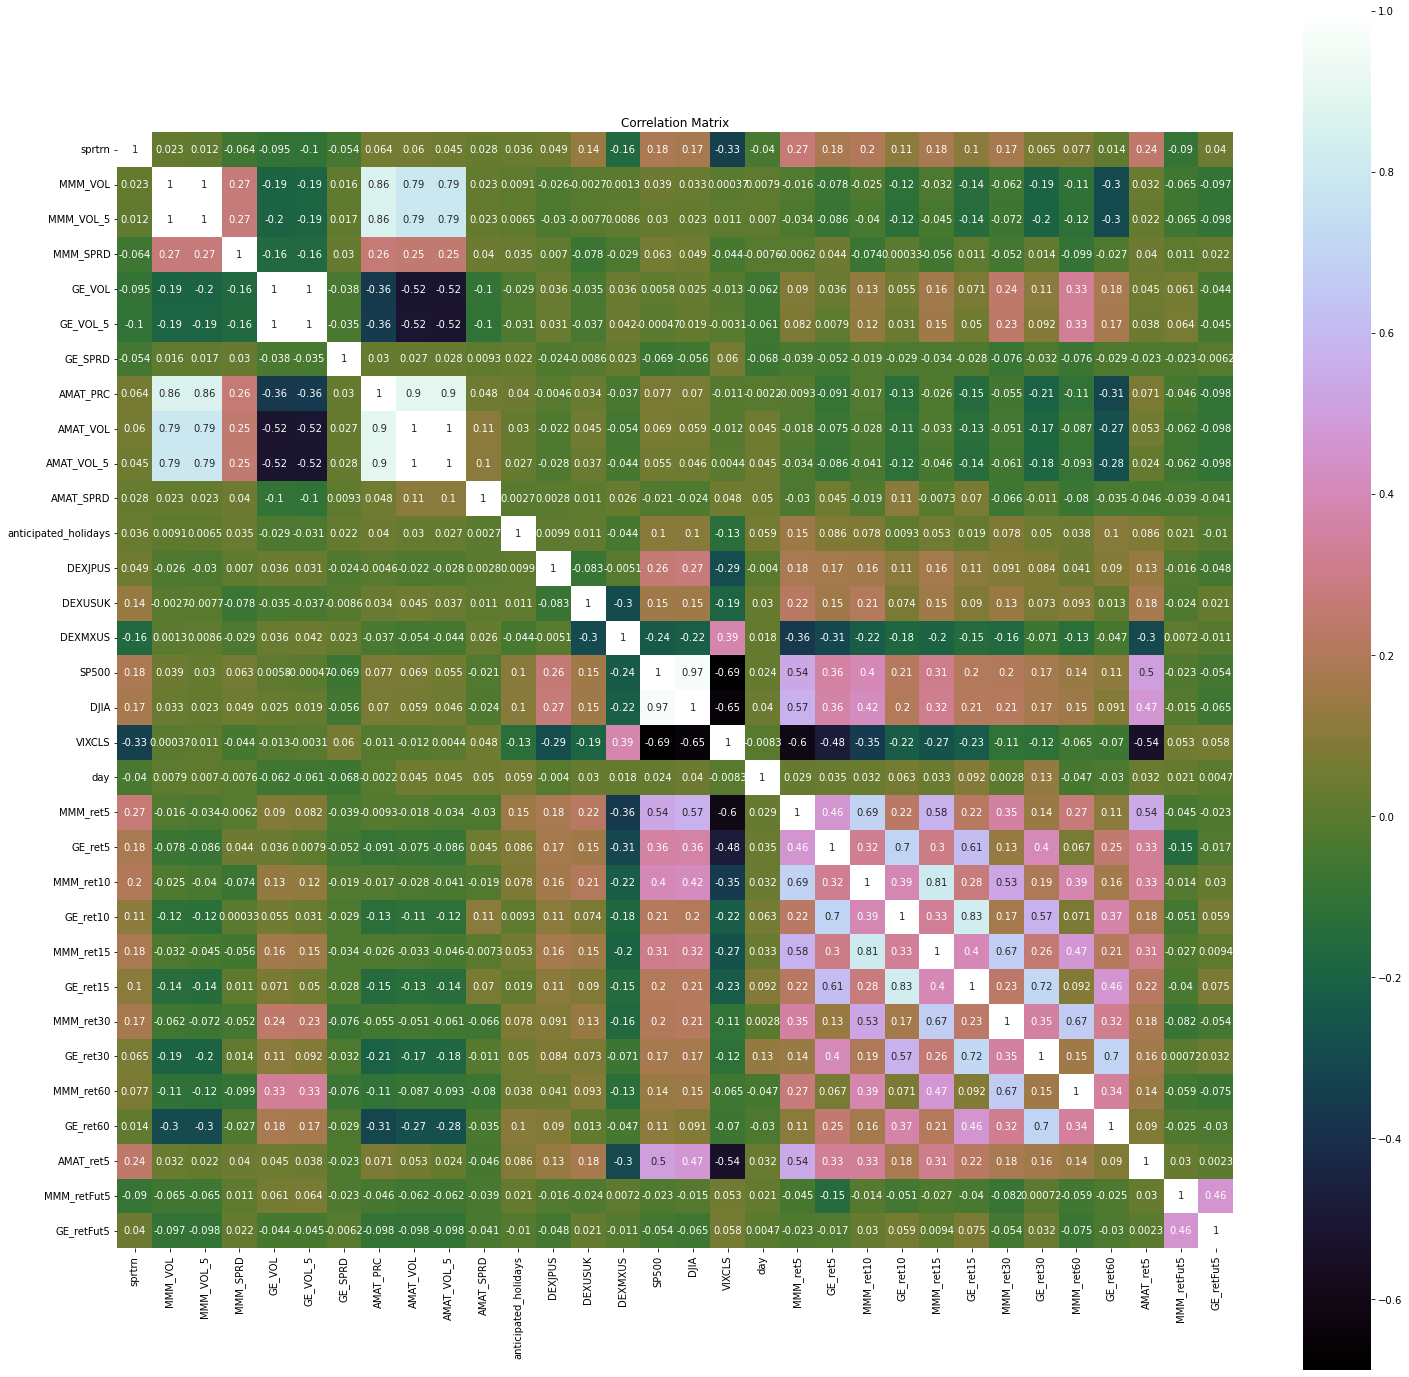

<Figure size 3600x3600 with 0 Axes>

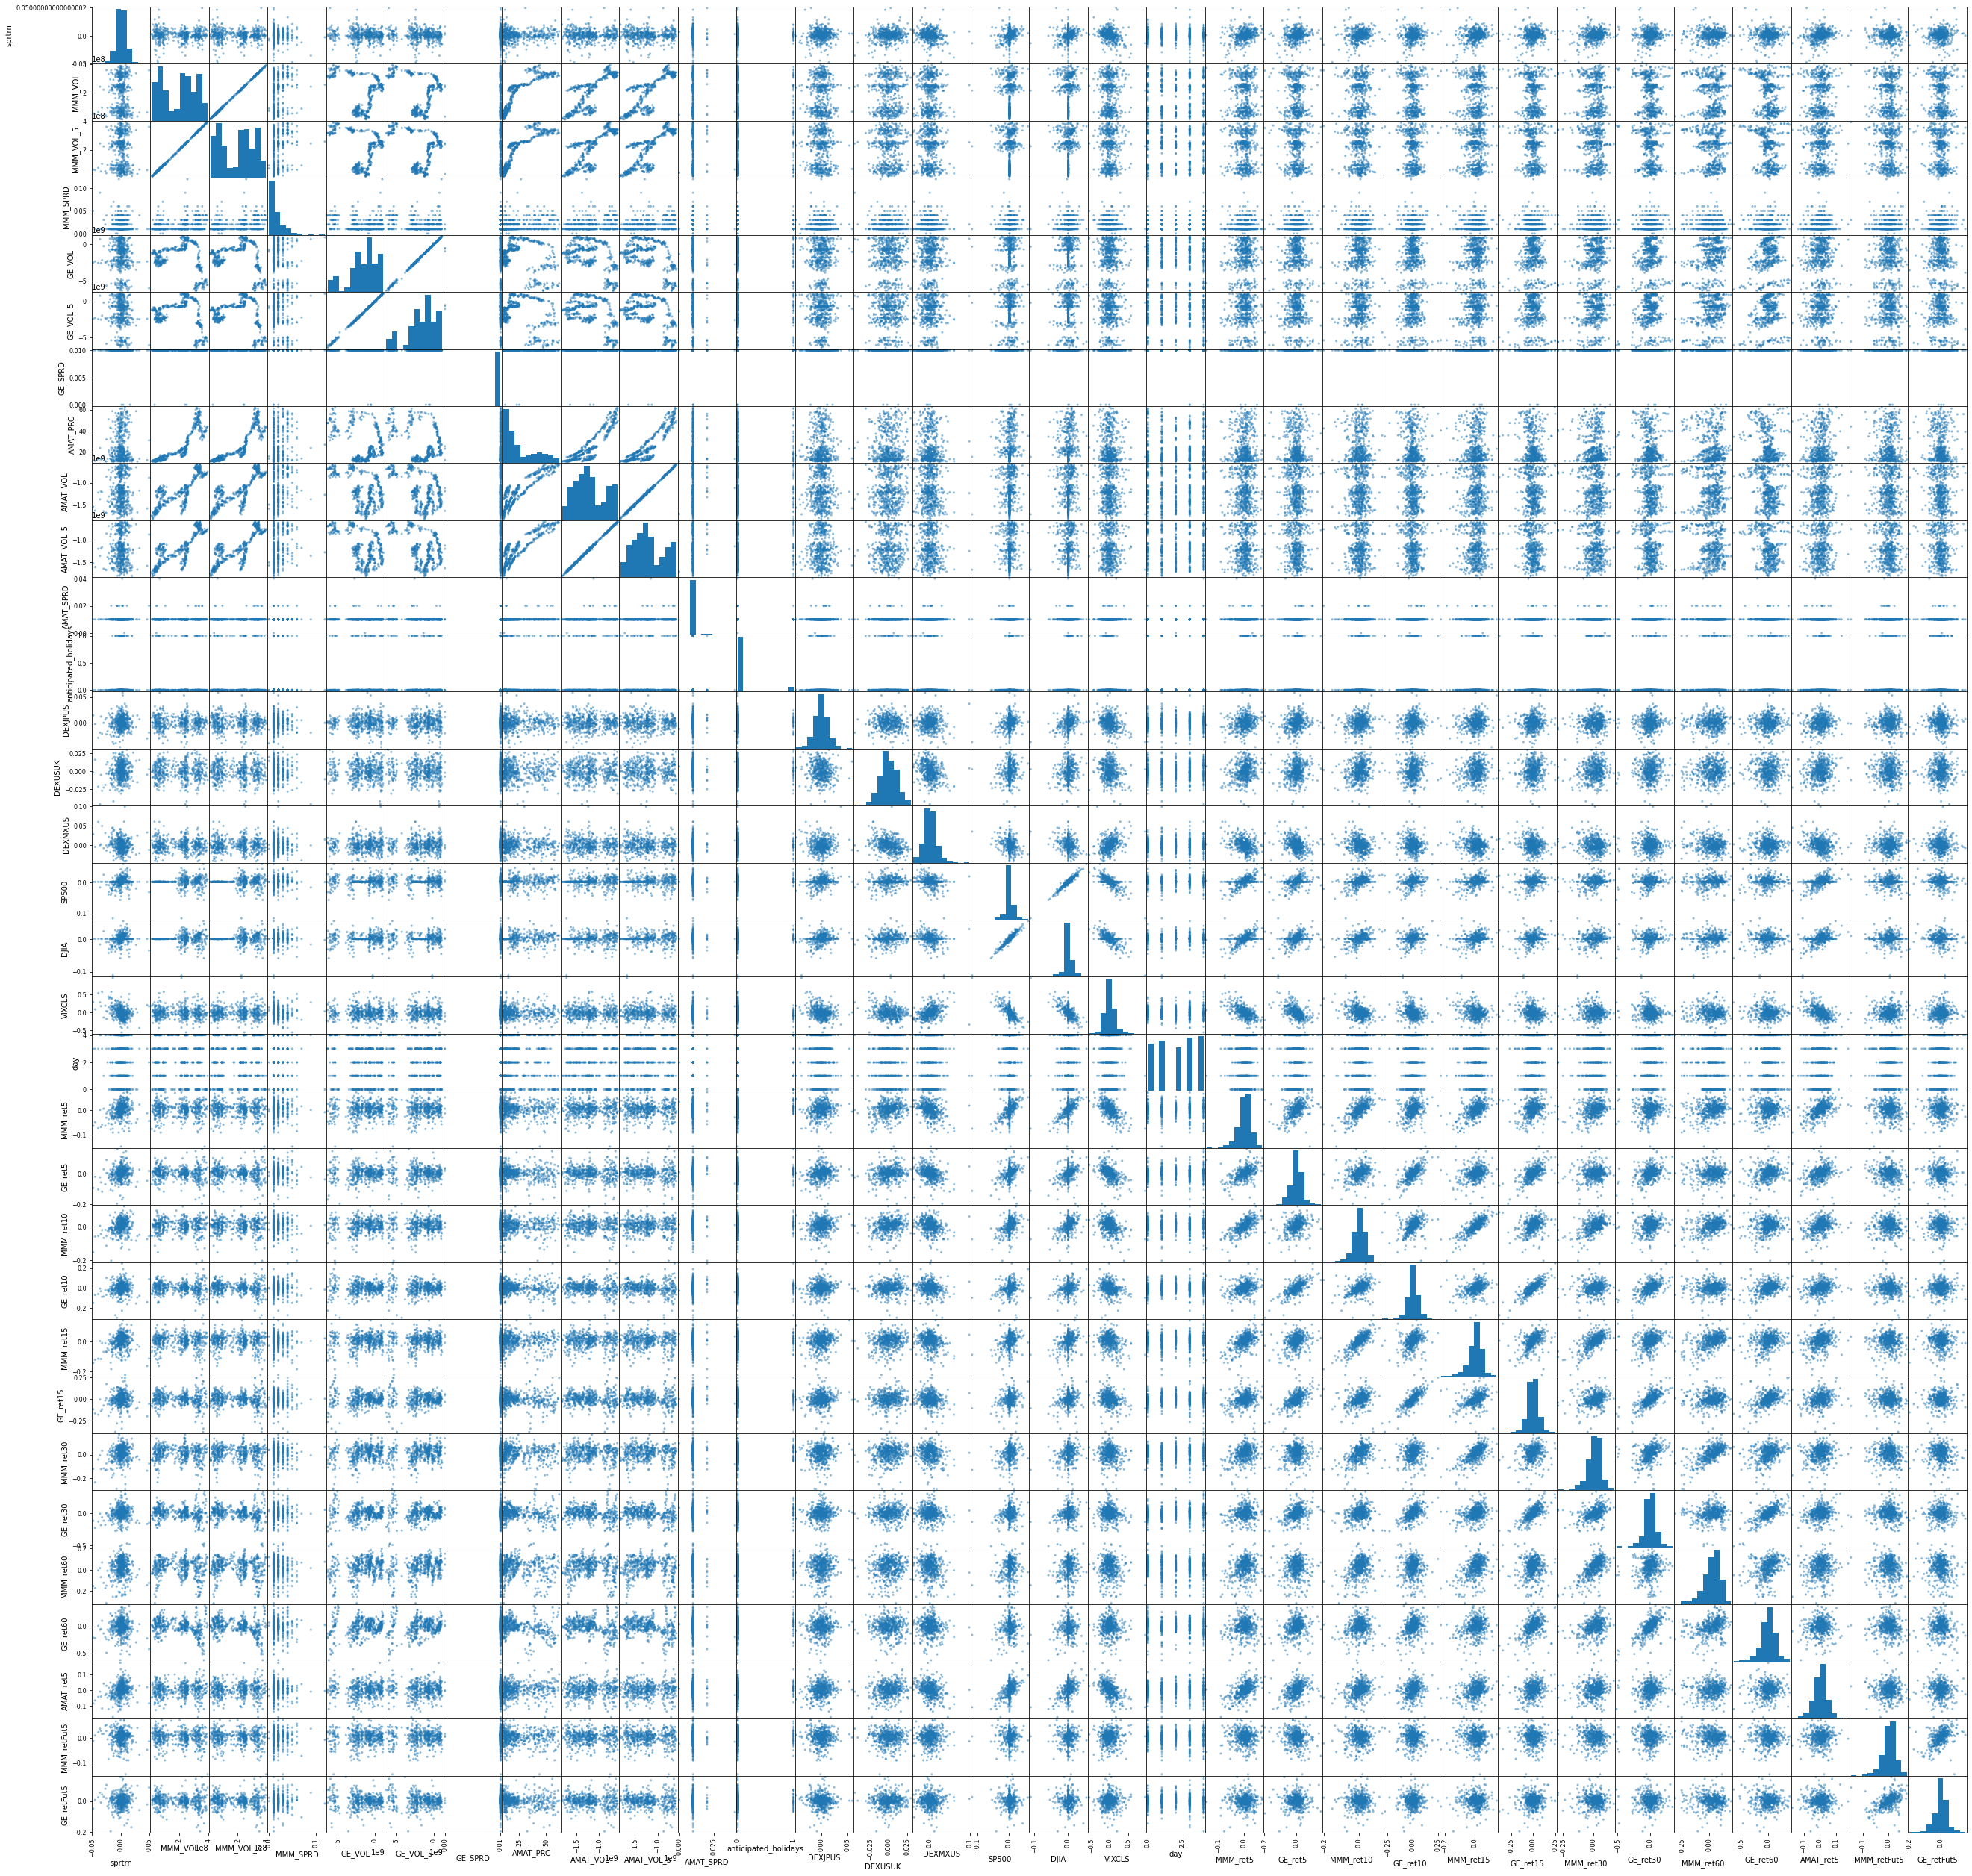

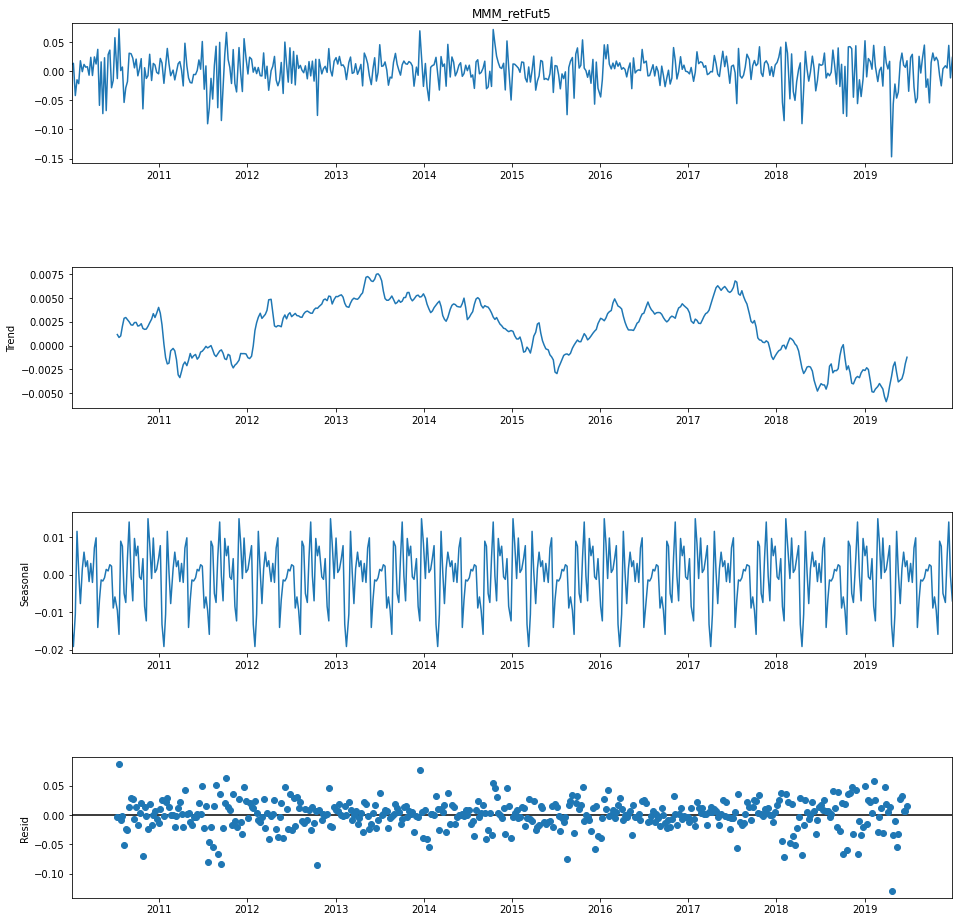

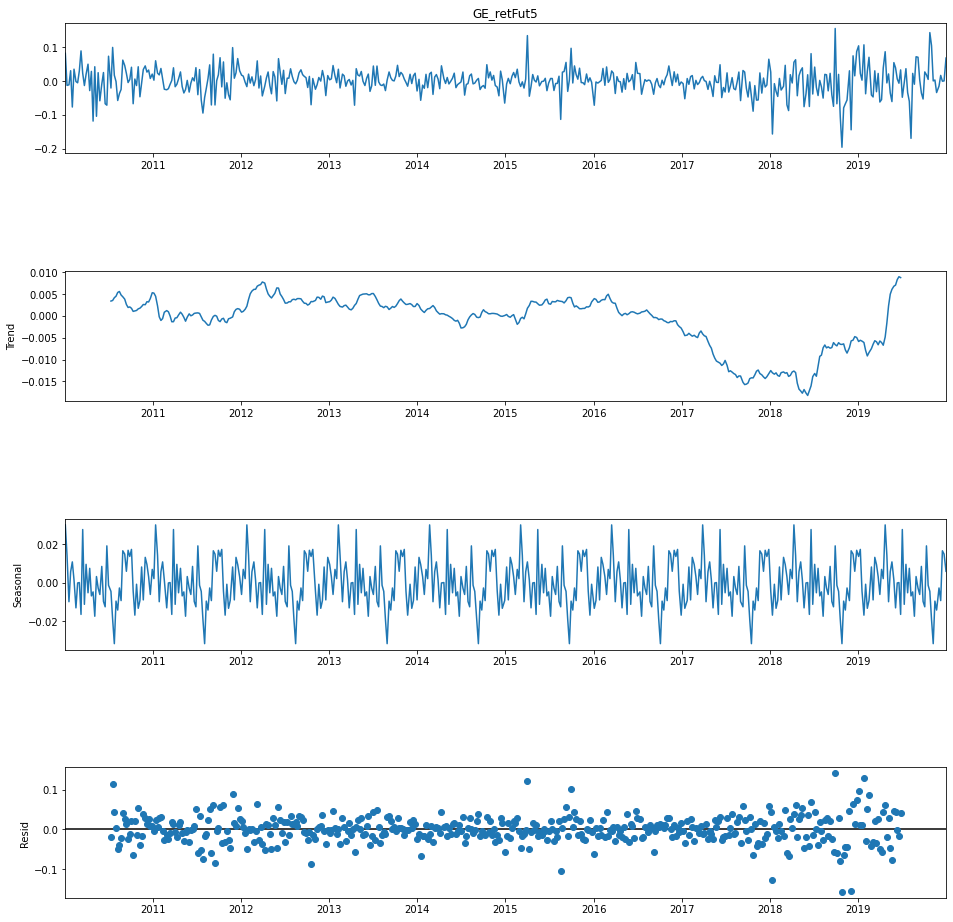

In [11]:
#Data Visualization

correlation = dataset.corr()
plt.figure(figsize=(25,25))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')



#Scatterplot Matrix

plt.figure(figsize=(50,50))
pd.plotting.scatter_matrix(dataset,figsize=(45,45))
plt.show()



#Time Series Analysis
#If using weekly data take 52 periods
#If using daily take 252

res = sm.tsa.seasonal_decompose(y['MMM_retFut5'], period = 52)
fig = res.plot()
#fig = res.plot(observed=True, seasonal=False, trend=False, resid=True)  #To zoom in on residuals
fig.set_figheight(15)
fig.set_figwidth(15)
plt.show()

res = sm.tsa.seasonal_decompose(y['GE_retFut5'], period = 52)
fig = res.plot()
#fig = res.plot(observed=True, seasonal=False, trend=False, resid=True)  #To zoom in on residuals
fig.set_figheight(15)
fig.set_figwidth(15)
plt.show()


As we have several more features than Tatsat, we use feature reduction methods to avoid the curse of dimensionality 
We will use PCA as our method of feature reduction. We will also one hot encode the day variable we generated for categorical processing.

We are keeping the first 5 principal components in our pipeline in hopes of getting results comparable to Tatsat.
This in addition to our 5 (once encoded) day features and anticipated holiday features will leave use with a number of features comparable to Tatsat. 

Note - running PCA on the X_train dataset (after scaling and without categorical features) shows 3 principal components contain 99% of the variance.

In [12]:
numeric_features_ix = X_train.select_dtypes(include=['float64']).columns
categorical_features_ix = X_train.select_dtypes(include=['int64']).columns

numeric_sub_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler()),
    ('pca', PCA(5) )]) 

categorical_sub_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_sub_pipeline, numeric_features_ix),
        ('cat', categorical_sub_pipeline, categorical_features_ix)], remainder='passthrough')


X_train_original = X_train.copy(deep = True)
X_test_original = X_test.copy(deep = True)
preprocessor.fit(X_train)
X_train = preprocessor.transform(X_train)
X_test = preprocessor.transform(X_test)

In [13]:
#Model Evaluation

models = []

models.append(('LR', LinearRegression())) 
models.append(('LASSO', MultiTaskLasso())) 
models.append(('EN', MultiTaskElasticNet())) 
models.append(('KNN', KNeighborsRegressor())) 
models.append(('CART', DecisionTreeRegressor())) 
models.append(('SVR', RegressorChain(SVR(), cv = 2) )) 
models.append(('BR',  RegressorChain(BayesianRidge(), cv = 2) ))  
models.append(('PLS', PLSRegression())) 


#Ensemble models - Boosting and bagging methods
models.append(('RC_ABR', RegressorChain(AdaBoostRegressor(), cv = 2) )) 
models.append(('RC_GBR', RegressorChain(GradientBoostingRegressor(), cv = 2) ) )
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))
models.append(('VR', RegressorChain(VotingRegressor( estimators = [ ('LASSO', Lasso()),
                                     ('EN', ElasticNet()), ('KNN', KNeighborsRegressor()),
                                     ('RC_ABR',  AdaBoostRegressor() ),]), cv =2
                                       )))


#Neural network algorithms
#models.append(('MLP', MLPRegressor(learning_rate_init=0.1, learning_rate = "adaptive"))) 

LR
LR  complete
LASSO
LASSO  complete
EN
EN  complete
KNN
KNN  complete
CART
CART  complete
SVR
SVR  complete
BR
BR  complete
PLS
PLS  complete
RC_ABR
RC_ABR  complete
RC_GBR
RC_GBR  complete
RFR
RFR  complete
ETR
ETR  complete
VR
VR  complete


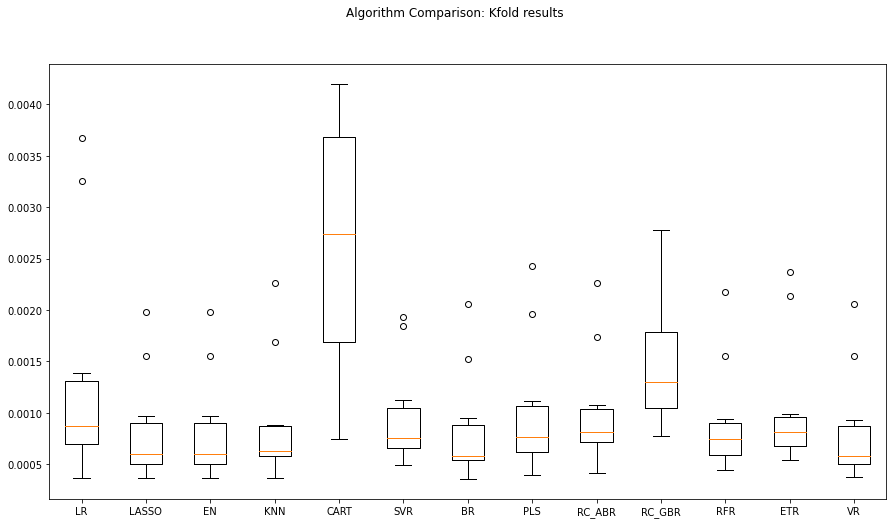

In [14]:
num_folds = 10
names = []
kfold_results = []
test_results = []
train_results = []
for name, model in models:
    names.append(name)
    ## k-fold analysis:
    splitter = TimeSeriesSplit(n_splits=num_folds)
    
    #converted mean squared error to positive. The lower the better
    cv_results = -1* cross_val_score(model, X_train, y_train, cv=splitter, scoring='neg_mean_squared_error')
    kfold_results.append(cv_results)
    
    # Full Training period
    res = model.fit(X_train, y_train)
    train_result = mean_squared_error(res.predict(X_train), y_train)
    train_results.append(train_result)
    
    # Test results
    test_result = mean_squared_error(res.predict(X_test), y_test)
    test_results.append(test_result)

    print (name)
    print (name, " complete")


#Results of the Comparisons
fig = plt.figure()
fig.suptitle('Algorithm Comparison: Kfold results')
ax = fig.add_subplot(111)
plt.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
plt.show()

## Daisy Chaining SARIMAX and Neural Network Models

In [15]:
#Time Series Models

#ARIMA Model
#Create Dataset for ARIMA model 
X_ARIMA = X.copy()

#Remove extra returns
for n in [5,10,15,30,60]:
    name = 'ret' + str(n)
    X_ARIMA.drop(["MMM_" + name], axis  = 1, inplace = True )
    X_ARIMA.drop(["GE_" + name], axis  = 1, inplace = True )

X_train_ARIMA = X_ARIMA[:-test_size]
X_test_ARIMA = X_ARIMA[-test_size:]


tr_len = len(X_train_ARIMA)
te_len = len(X_test_ARIMA)
to_len = len (X)

#NOTE SARIMAX models cannot process multi-target regression
#We train a model for each target series and will combine them to compare for out multi-target regression.

MMM_modelARIMA=ARIMA(endog=y_train["MMM_retFut5"] ,exog=X_train_ARIMA ,order=[1,0,0])
MMM_model_fit = MMM_modelARIMA.fit()
MMM_error_Training_ARIMA = mean_squared_error(y_train["MMM_retFut5"], MMM_model_fit.fittedvalues)
MMM_predicted = MMM_model_fit.predict(start = tr_len -1 ,end = to_len -1, exog = X_test_ARIMA)[1:]
MMM_error_Test_ARIMA = mean_squared_error(y_test["MMM_retFut5"],MMM_predicted)
MMM_error_Test_ARIMA


X_train_ARIMA = pd.concat([X_train_ARIMA, MMM_model_fit.fittedvalues], axis = 1, copy = False)
MMM_predicted = pd.DataFrame(MMM_predicted)
MMM_predicted["date"]= X_test_ARIMA.index
MMM_predicted.set_index(["date"], inplace = True)
X_test_ARIMA = pd.concat([X_test_ARIMA, MMM_predicted], axis = 1, copy = False)

GE_modelARIMA=ARIMA(endog=y_train["GE_retFut5"] ,exog=X_train_ARIMA ,order=[1,0,0])
GE_model_fit = GE_modelARIMA.fit()
GE_error_Training_ARIMA = mean_squared_error(y_train["GE_retFut5"], GE_model_fit.fittedvalues)
GE_predicted = GE_model_fit.predict(start = tr_len -1 ,end = to_len -1, exog = X_test_ARIMA)[1:]
GE_error_Test_ARIMA = mean_squared_error(y_test["GE_retFut5"],GE_predicted)
GE_error_Test_ARIMA


error_Training_ARIMA = MMM_error_Training_ARIMA + GE_error_Training_ARIMA
error_Test_ARIMA = MMM_error_Test_ARIMA + GE_error_Test_ARIMA

(504, 10)




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where










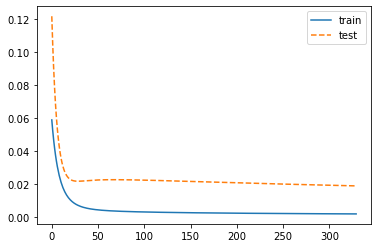

In [16]:
#LSTM Model

#X_LSTM = pd.concat( [X_train, X_test], axis = 1, copy = False) #Needs conversion back to dataframes

X_LSTM = np.row_stack( (X_train, X_test))
print (X_LSTM.shape)

seq_len = 2 #Length of the seq for the LSTM

y_train_LSTM, y_test_LSTM = np.array(y_train)[seq_len-1:], np.array(y_test)
X_train_LSTM = np.zeros((X_train.shape[0]+1-seq_len, seq_len, X_train.shape[1]))
X_test_LSTM = np.zeros((X_test.shape[0], seq_len, X_LSTM.shape[1]))

for i in range(seq_len):
    X_train_LSTM[:, i, :] = np.array(X_train)[i:X_train.shape[0]+i+1-seq_len, :]
    X_test_LSTM[:, i, :] = np.array(X_LSTM)\
    [X_train.shape[0]+i-1:X_LSTM.shape[0]+i+1-seq_len, :]


# LSTM Network
def create_LSTMmodel(learn_rate = 0.01, momentum=0):
        # create model
    model = Sequential()
    model.add(LSTM(50, input_shape=(X_train_LSTM.shape[1],\
      X_train_LSTM.shape[2])))
    #More cells can be added if needed
    model.add(Dense(2))
    optimizer = SGD(lr=learn_rate, momentum=momentum)
    model.compile(loss='mse', optimizer= optimizer)
    #model.compile(loss='mse', optimizer='adam')
    return model
LSTMModel = create_LSTMmodel(learn_rate = 0.01, momentum=0)

LSTMModel_fit = LSTMModel.fit(X_train_LSTM, y_train_LSTM, 
                              validation_data=(X_test_LSTM, y_test_LSTM), 
                              epochs=330, batch_size=72, verbose=0, shuffle=False)

plt.plot(LSTMModel_fit.history['loss'], label='train', )
plt.plot(LSTMModel_fit.history['val_loss'], '--',label='test',)
plt.legend()
plt.show()

error_Training_LSTM = mean_squared_error(y_train_LSTM,\
  LSTMModel.predict(X_train_LSTM))
predicted = LSTMModel.predict(X_test_LSTM)
error_Test_LSTM = mean_squared_error(y_test,predicted)


def GBM_LSTMmodel(X_train, y_train, X_test, y_test ):
    KR_LSTM = KerasRegressor(build_fn = create_LSTMmodel,epochs=330, batch_size=72, verbose=0, shuffle=False)
    KR_LSTM.fit(X_train, y_train)
    y_train2 = y_train - KR_LSTM.predict(X_train)
    KR_LSTM2 = KerasRegressor(build_fn = create_LSTMmodel,epochs=330, batch_size=72, verbose=0, shuffle=False)
    KR_LSTM2.fit(X_train, y_train2)
    error_Training_GBM_LSTM = mean_squared_error (y_train,
                                                  sum(KR.predict(X_train) for KR in [KR_LSTM, KR_LSTM2]))
    error_Test_GBM_LSTM = mean_squared_error (y_test,
                                                  sum(KR.predict(X_test) for KR in [KR_LSTM, KR_LSTM2]))
    return error_Training_GBM_LSTM, error_Test_GBM_LSTM


error_Training_GBM_LSTM, error_Test_GBM_LSTM = GBM_LSTMmodel(X_train_LSTM, y_train_LSTM, X_test_LSTM, y_test_LSTM)


def vLSTMmodel(X_train, y_train, X_test, y_test, n_estimators = 3):
    estimators = []
    for i in range(n_estimators):
        KR_LSTM = KerasRegressor(build_fn = create_LSTMmodel,epochs=330, batch_size=72, verbose=0, shuffle=False)
        KR_LSTM.fit(X_train, y_train, validation_data=(X_test_LSTM, y_test_LSTM))
        estimators.append(KR_LSTM)

    error_Training_vLSTM = mean_squared_error (y_train,
                                                  (1/len(estimators))*sum(estimator.predict(X_train) for estimator in estimators))
    error_Test_vLSTM = mean_squared_error (y_test,
                                                  (1/len(estimators))*sum(estimator.predict(X_test) for estimator in estimators))
    return error_Training_vLSTM, error_Test_vLSTM

error_Training_vLSTM, error_Test_vLSTM = vLSTMmodel(X_train_LSTM, y_train_LSTM, X_test_LSTM, y_test_LSTM, n_estimators = 3)



## Base Model Error Results

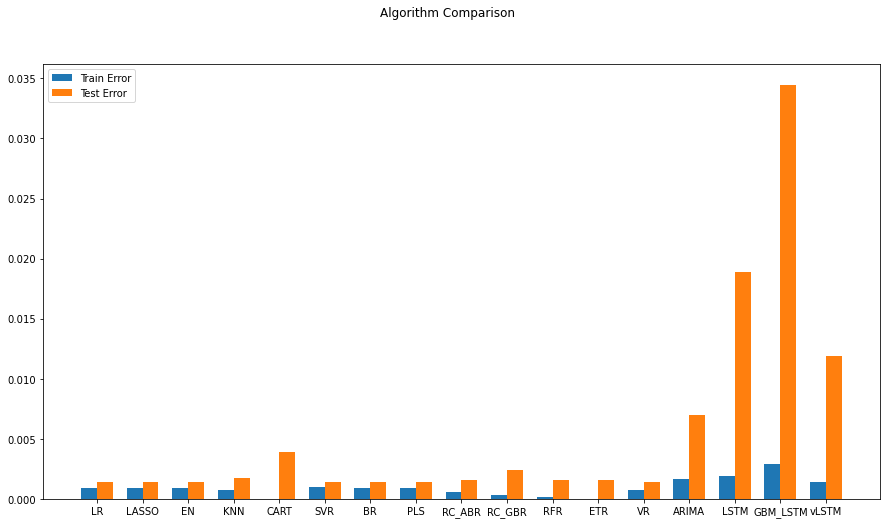

Best model is  BR


In [17]:
#Add Time Series Model results to our model results

test_results.append(error_Test_ARIMA)
test_results.append(error_Test_LSTM)
test_results.append(error_Test_GBM_LSTM)
test_results.append(error_Test_vLSTM)

train_results.append(error_Training_ARIMA)
train_results.append(error_Training_LSTM)
train_results.append(error_Training_GBM_LSTM)
train_results.append(error_Training_vLSTM)

names.append("ARIMA")
names.append("LSTM")
names.append("GBM_LSTM")
names.append("vLSTM")


# compare algorithms
fig = plt.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.bar(ind - width/2, train_results,  width=width, label='Train Error')
plt.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
plt.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
plt.show()


#Determine Best models
bestIndex = np.argmin(np.array(test_results))
print("Best model is ", names[bestIndex])

## Gridsearch - Hyperparameter Tuning the best base model

In [18]:
#GridSearch Bayesian Ridge Regression parameters

#alpha_1, alpha_2
#lambda_1, lambda_2
#All vary from 1*10^-8 to 10^-5

pipe = Pipeline(steps=[('preprocessor', preprocessor), ("RC_BR",RegressorChain(BayesianRidge(), cv = 2))])

BR_alpha_1 = np.logspace(-8, -5, num=6, endpoint = True)
BR_alpha_2 = np.logspace(-8, -5, num=6, endpoint = True)
BR_lambda_1 = np.logspace(-8, -5, num=6, endpoint = True)
BR_lambda_2 = np.logspace(-8, -5, num=6, endpoint = True)


param_grid =  [{'RC_BR__base_estimator__alpha_1': BR_alpha_1, 'RC_BR__base_estimator__alpha_2': BR_alpha_2,
                'RC_BR__base_estimator__lambda_1': BR_lambda_1, 'RC_BR__base_estimator__lambda_2': BR_lambda_2}]


grid_search = GridSearchCV(pipe, param_grid, cv=splitter, scoring='neg_mean_squared_error', return_train_score=True)


grid_search.fit(X_train_original, y_train)

best_parameters = grid_search.best_params_
best_model = grid_search.best_estimator_
print("Best parameters : {}".format(best_parameters))
#print('Best estimator {}'.format(best_model))
print("Best cross-validation score : {:.2f}".format(grid_search.best_score_*100))
results = pd.DataFrame(grid_search.cv_results_)

Best parameters : {'RC_BR__base_estimator__alpha_1': 1e-08, 'RC_BR__base_estimator__alpha_2': 1e-05, 'RC_BR__base_estimator__lambda_1': 1e-05, 'RC_BR__base_estimator__lambda_2': 1e-08}
Best cross-validation score : -4332482429891795968.00


In [19]:
def MaxDrawDown(cumulative_returns):
    high = np.zeros(len(cumulative_returns))
    drawdown      = np.zeros(len(cumulative_returns))
    duration = np.zeros(len(cumulative_returns))
    for t in range(1, len(cumulative_returns)):
        high[t] = np.max([high[t-1], cumulative_returns[t]])
        drawdown[t] = (1+cumulative_returns[t]) / (1 + high[t]) - 1
        if (drawdown[t]==0):
            duration[t] = 0
        else:
            duration[t] = duration[t-1] + 1
    return np.min(drawdown), np.max(duration)

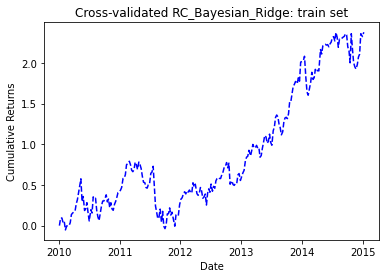

In-sample: CAGR=2.35932 Sharpe ratio=1.87539 maxDD=-0.462061 maxDDD=95 Calmar ratio=5.10607



In [20]:
predictions_tr = pd.DataFrame (grid_search.predict(X_train_original), columns = y_train.columns, index = y_train.index)
positions = np.where(predictions_tr > 0,1,-1 ) 
dailyRet = pd.DataFrame(positions).shift(1).fillna(0).values * X_train_original[["MMM_ret5","GE_ret5"]]#for trading at the close
dailyRet = dailyRet.fillna(0)
cumret = np.cumprod(dailyRet.sum(axis = 1) + 1) - 1 #Want return of all the stocks together

plt.figure(1)
plt.plot(cumret.index, cumret, 'b--', label = 'predicted')
plt.title('Cross-validated RC_Bayesian_Ridge: train set')
plt.ylabel('Cumulative Returns')
plt.xlabel('Date')
plt.show()


cagr = (1 + cumret[-1]) ** (252 / len(cumret)) - 1
maxDD, maxDDD = MaxDrawDown(cumret)
#ratio = (252.0 ** (1.0/2.0)) * np.mean(dailyRet) / np.std(dailyRet)
ratio = (252.0 ** (1.0/2.0)) * np.mean(dailyRet.sum(axis = 1)) / np.std(dailyRet.sum(axis = 1))
print (('In-sample: CAGR={:0.6} Sharpe ratio={:0.6} maxDD={:0.6} maxDDD={:d} Calmar ratio={:0.6}\n'\
).format(cagr, ratio, maxDD, maxDDD.astype(int), -cagr/maxDD))


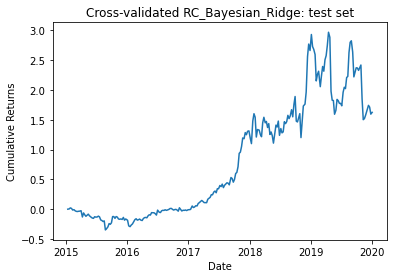

Out-of-sample: CAGR=1.6337 Sharpe ratio=1.59776 maxDD=-0.369564 maxDDD=89 Calmar ratio=4.42062 



In [21]:
predictions_test = pd.DataFrame (grid_search.predict(X_test_original), columns = y_test.columns, index = y_test.index)
positions2 = np.where(predictions_test> 0,1,-1 ) 

dailyRet2 = pd.DataFrame(positions2).shift(1).fillna(0).values * X_test_original[["MMM_ret5","GE_ret5"]] #for trading at the close
dailyRet2 = dailyRet2.fillna(0)
cumret2 = np.cumprod(dailyRet2.sum(axis = 1) + 1) - 1 #Want return of all the stocks together

plt.figure(2)
plt.plot(cumret2.index, cumret2)
plt.title('Cross-validated RC_Bayesian_Ridge: test set')
plt.ylabel('Cumulative Returns')
plt.xlabel('Date')
plt.show()


cagr = (1 + cumret2[-1]) ** (252 / len(cumret2)) - 1
maxDD, maxDDD = MaxDrawDown(cumret2)
ratio = (252.0 ** (1.0/2.0)) * np.mean(dailyRet2.sum(axis = 1)) / np.std(dailyRet2.sum(axis = 1))
print (('Out-of-sample: CAGR={:0.6} Sharpe ratio={:0.6} maxDD={:0.6} maxDDD={:d} Calmar ratio={:0.6} \n'\
).format(cagr, ratio, maxDD, maxDDD.astype(int), -cagr/maxDD))

    


## AlphaLens - Evaluating the Validity and Usefulness of the Best Model's Predictions

Dropped 76.2% entries from factor data: 76.1% in forward returns computation and 0.1% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 6000.0%, not exceeded: OK!
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 980 entries, (Timestamp('2010-01-11 00:00:00-0500', tz='EST', freq='C'), 'GE') to (Timestamp('2019-10-04 00:00:00-0500', tz='EST', freq='C'), 'MMM')
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   5D               980 non-null    float64
 1   10D              980 non-null    float64
 2   15D              980 non-null    float64
 3   30D              980 non-null    float64
 4   60D              980 non-null    float64
 5   factor           980 non-null    float64
 6   factor_quantile  980 non-null    float64
dtypes: float64(7)
memory usage: 140.9+ KB
None
Quantiles Statistics


min       max      mean       std  count  count %
factor_quantile                                                        
1.0             -0.195864  0.072418 -0.010961  0.030940    490     50.0
5.0             -0.086207  0.169548  0.017313  0.030056    490     50.0

Returns Analysis


5D    10D    15D    30D  \
Ann. alpha                                     0.022  0.020 -0.013 -0.004   
beta                                           0.065  0.096  0.067  0.092   
Mean Period Wise Return Top Quantile (bps)     4.619  4.398 -2.138 -0.151   
Mean Period Wise Return Bottom Quantile (bps) -4.619 -4.400  2.137  0.151   
Mean Period Wise Spread (bps)                  9.238  8.800 -4.297 -0.313   

                                                 60D  
Ann. alpha                                    -0.005  
beta                                           0.066  
Mean Period Wise Return Top Quantile (bps)    -0.457  
Mean Period Wise Return Bottom Quantile (bps)  0.456  
Mean Period Wise Spread (bps)                 -0.898

Information Analysis


5D    10D    15D    30D    60D
IC Mean           0.045 -0.008 -0.029  0.004  0.000
IC Std.           1.000  1.001  1.001  1.001  1.001
Risk-Adjusted IC  0.045 -0.008 -0.029  0.004  0.000
t-stat(IC)          NaN    NaN    NaN    NaN    NaN
p-value(IC)         NaN    NaN    NaN    NaN    NaN
IC Skew             NaN    NaN    NaN    NaN    NaN
IC Kurtosis         NaN    NaN    NaN    NaN    NaN

Turnover Analysis


5D    10D    15D    30D    60D
Quantile 1 Mean Turnover   0.527  0.509  0.481  0.501  0.486
Quantile 2 Mean Turnover     NaN    NaN    NaN    NaN    NaN
Quantile 3 Mean Turnover     NaN    NaN    NaN    NaN    NaN
Quantile 4 Mean Turnover     NaN    NaN    NaN    NaN    NaN
Quantile 5 Mean Turnover   0.527  0.509  0.481  0.501  0.486

5D    10D    15D    30D    60D
Mean Factor Rank Autocorrelation -0.053 -0.018  0.037 -0.002  0.027

<Figure size 432x288 with 0 Axes>

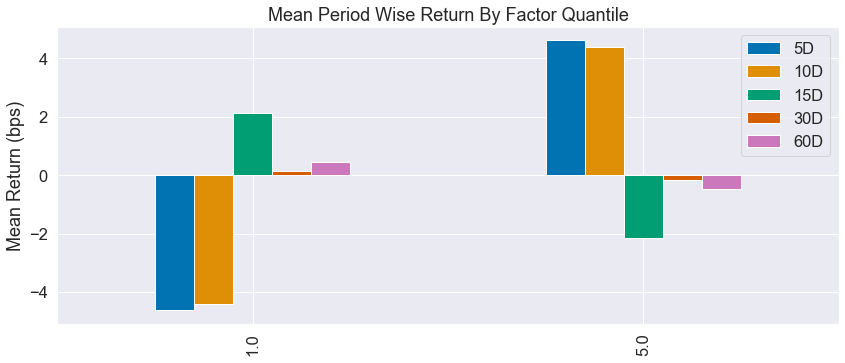

Quantiles Statistics


min       max      mean       std  count  count %
factor_quantile                                                        
1.0             -0.195864  0.072418 -0.010961  0.030940    490     50.0
5.0             -0.086207  0.169548  0.017313  0.030056    490     50.0

Returns Analysis


5D    10D    15D    30D  \
Ann. alpha                                     0.022  0.020 -0.013 -0.004   
beta                                           0.065  0.096  0.067  0.092   
Mean Period Wise Return Top Quantile (bps)     4.619  4.398 -2.138 -0.151   
Mean Period Wise Return Bottom Quantile (bps) -4.619 -4.400  2.137  0.151   
Mean Period Wise Spread (bps)                  9.238  8.800 -4.297 -0.313   

                                                 60D  
Ann. alpha                                    -0.005  
beta                                           0.066  
Mean Period Wise Return Top Quantile (bps)    -0.457  
Mean Period Wise Return Bottom Quantile (bps)  0.456  
Mean Period Wise Spread (bps)                 -0.898

<Figure size 432x288 with 0 Axes>

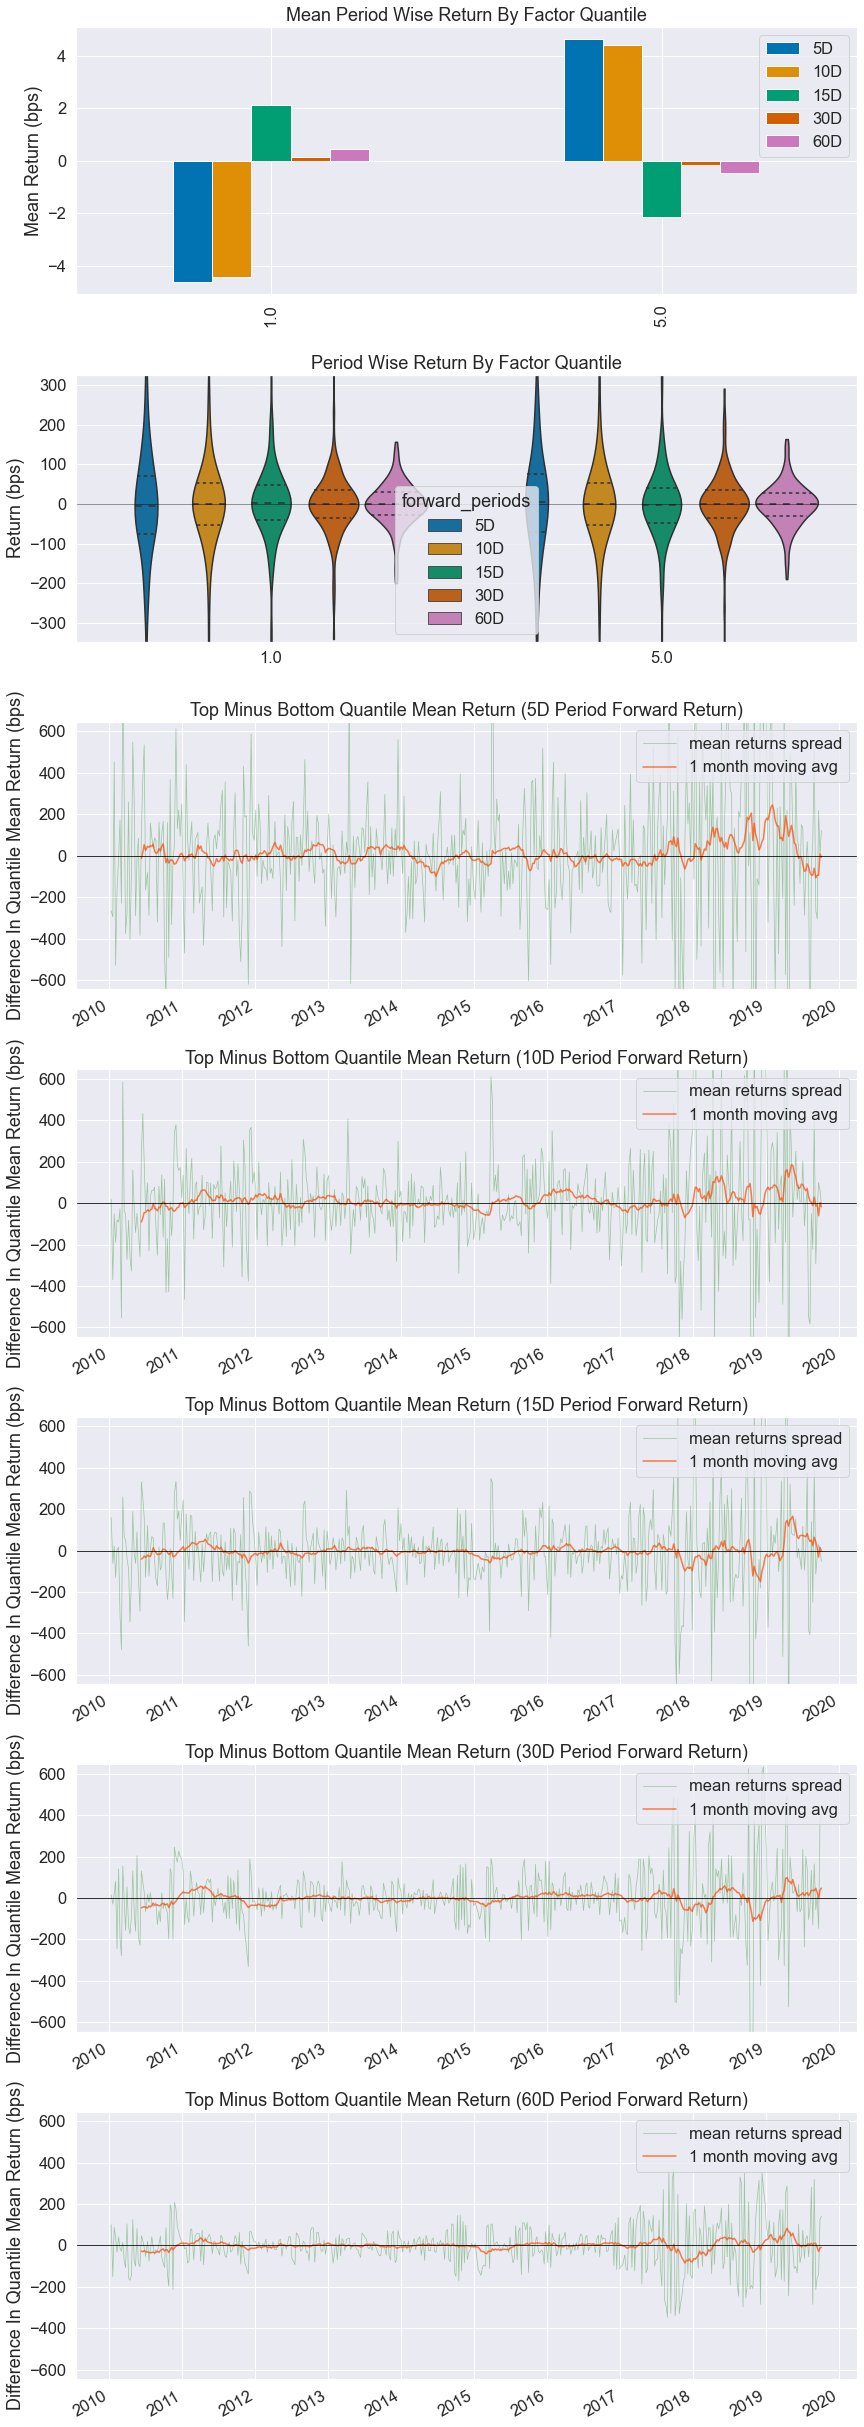

Information Analysis


5D    10D    15D    30D    60D
IC Mean           0.045 -0.008 -0.029  0.004  0.000
IC Std.           1.000  1.001  1.001  1.001  1.001
Risk-Adjusted IC  0.045 -0.008 -0.029  0.004  0.000
t-stat(IC)          NaN    NaN    NaN    NaN    NaN
p-value(IC)         NaN    NaN    NaN    NaN    NaN
IC Skew             NaN    NaN    NaN    NaN    NaN
IC Kurtosis         NaN    NaN    NaN    NaN    NaN

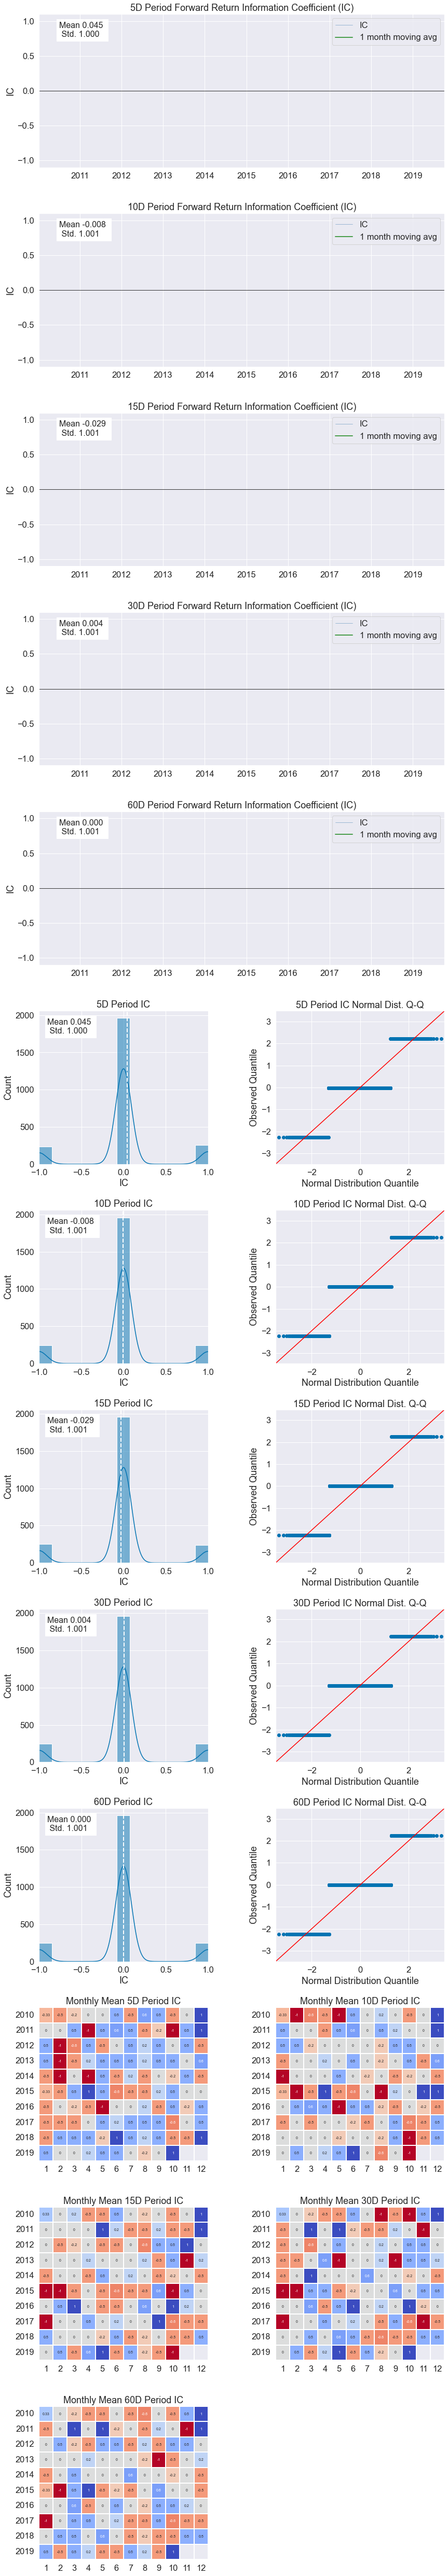

Turnover Analysis


5D    10D    15D    30D    60D
Quantile 1.0 Mean Turnover   0.527  0.509  0.481  0.501  0.486
Quantile 5.0 Mean Turnover   0.527  0.509  0.481  0.501  0.486

5D    10D    15D    30D    60D
Mean Factor Rank Autocorrelation -0.053 -0.018  0.037 -0.002  0.027

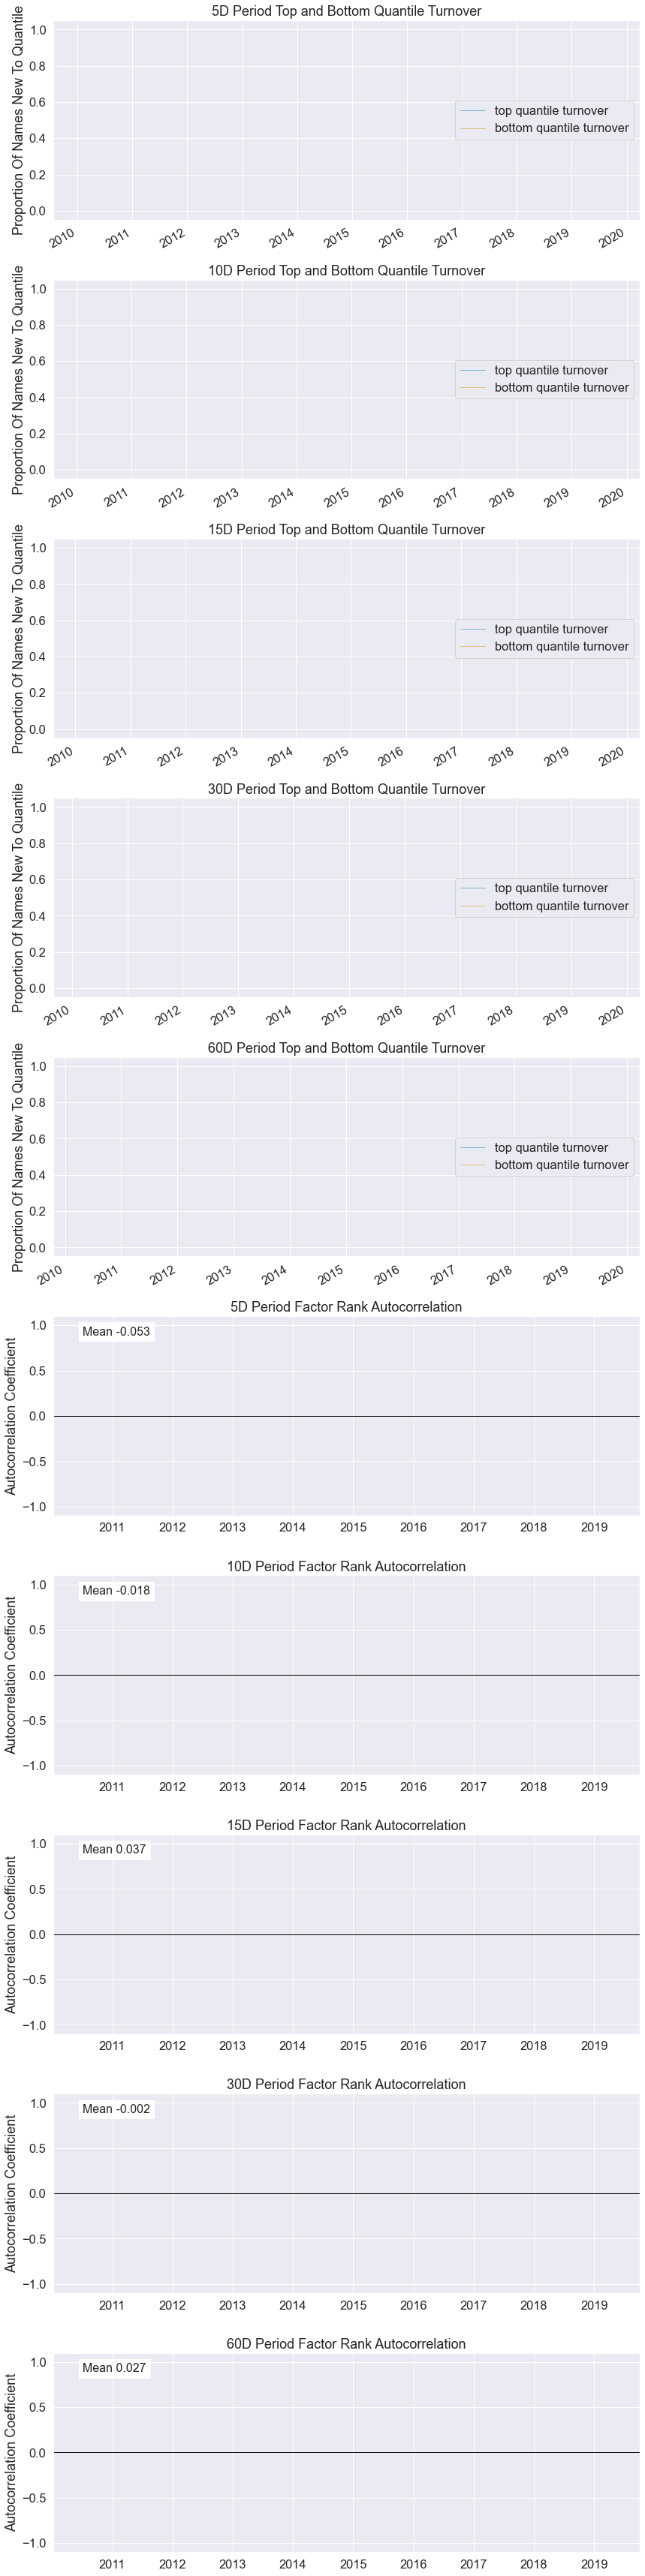

In [22]:
#AlphaLens 

return_pred = pd.concat([dailyRet,dailyRet2])
df3 = df.loc[df.index.get_level_values("TICKER") == "GE"]
df3.reset_index(inplace = True)
df3["date"]= pd.to_datetime(df3['date'], infer_datetime_format=True)
df3.set_index(["date"], inplace = True)
df3 = df3.loc[df3.index.get_level_values("date") >= return_pred.index[0]]
df3 = df3.loc[df3.index.get_level_values("date") <= return_pred.index[return_pred.shape[0]-1]]
df3.drop(["PERMNO", "HSICMG", "VOL", "ASK", "BID", "OPENPRC", "sprtrn"], axis = 1, inplace = True)
df3["ret"]= return_pred["GE_ret5"]

df4 = df.loc[df.index.get_level_values("TICKER") == "MMM"]
df4.reset_index(inplace = True)
df4["date"]= pd.to_datetime(df4['date'], infer_datetime_format=True)
df4.set_index(["date"], inplace = True)
df4 = df4.loc[df4.index.get_level_values("date") >= return_pred.index[0]]
df4 = df4.loc[df4.index.get_level_values("date") <= return_pred.index[return_pred.shape[0]-1]]
df4.drop(["PERMNO", "HSICMG", "VOL", "ASK", "BID", "OPENPRC", "sprtrn"], axis = 1, inplace = True)
df4["ret"]= return_pred["MMM_ret5"]

factor = pd.concat([df4, df3], axis = 0, copy = True)
factor.set_index(["TICKER",factor.index], inplace = True)
factors = factor.swaplevel().tz_localize('EST', level='date').sort_index()
factors = factors.drop_duplicates(keep='first') 
factors.drop(["PRC"], axis = 1,inplace = True)

df5 = df.copy(deep = True)
df5.reset_index(inplace = True)
df5["date"]= pd.to_datetime(df5['date'], infer_datetime_format=True)
df5.set_index(["date"], inplace = True)
df5 = df5.loc[df5.index.get_level_values("date") >= return_pred.index[0]]
df5 = df5.loc[df5.index.get_level_values("date") <= return_pred.index[return_pred.shape[0]-1]]
df5.index.tz_localize('EST')
price = df5.pivot_table(index = 'date', columns = 'TICKER',values='PRC')
price.drop(["ACN", "ADI", "AMAT"], axis = 1, inplace = True)
price.index = price.index.tz_localize('EST')

alpha_data = get_clean_factor_and_forward_returns(factor = factors,
                                                    prices = price,
                                                    quantiles=5,
                                                    periods=(5, 10, 15, 30, 60),
                                                    max_loss = 60)

print(alpha_data.info())

create_summary_tear_sheet(alpha_data)

alphalens.tears.create_full_tear_sheet(alpha_data, long_short=True, group_neutral=False, by_group=False)